# Facial Recognition Using Convolutional Neural Networks
###### _Code and commentary by Alan Li_
___
Basic understanding of machine learning concepts such as gradient descent and regularization is assumed.
### Convolutional Neural Networks (CNN)
___
Introduction about CNNs...

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing

np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)
tf.set_random_seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/Users/alanli/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### The FaceScrub Data
___
The [FaceScrub](http://vintage.winklerbros.net/facescrub.html) dataset consists of over 100,000 face images of 530 people, both male and female. Only a subset of the FaceScrub dataset is used for this project, 3 female subjects and 3 male subjects:
1. Female - 
2. Female - 
3. Female - 
4. Male - 
5. Male - 
6. Male - 

Let's load the data first. The function used to load the data can be used for both facial recognition as well as gender recognition.

In [2]:
def load_face_data(data_path, target_path, task=0):
    # task = 0 >> face recognition
    # task = 1 >> gender recognition
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    target = np.load(target_path)
    
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
    data[rnd_idx[trBatch+1:trBatch + validBatch],:], \
    data[rnd_idx[trBatch + validBatch+1:-1],:]

    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
    target[rnd_idx[trBatch+1:trBatch + validBatch], task], \
    target[rnd_idx[trBatch + validBatch + 1:-1], task]
    
    if task == 0:
        # encode scalar targets to n x 10 arrays
        lb = preprocessing.LabelBinarizer()
        lb.fit(np.sort(trainTarget))
        trainTarget = lb.transform(trainTarget)
        validTarget = lb.transform(validTarget)
        testTarget = lb.transform(testTarget)
    elif task == 1:
        trainTarget = two_class_onehot(trainTarget)
        validTarget = two_class_onehot(validTarget)
        testTarget = two_class_onehot(testTarget)
    
    return trainData, validData, testData, trainTarget, validTarget, testTarget

def two_class_onehot(binary_label):
    binary_label_one_hot = np.zeros((binary_label.shape[0], 2))
    label_range = np.arange(binary_label.shape[0])
    binary_label_one_hot[label_range, binary_label] = 1
    return binary_label_one_hot

# set recognition task: 0 for face, 1 for gender
task = 0

# load data
trainData, validData, testData, trainTarget, validTarget, testTarget\
= load_face_data("./data/facescrub/data.npy", "./data/facescrub/target.npy", task=task)
train_idx = np.arange(trainData.shape[0]) 

### Data Visualization
___
It's good pratice to visualize the data prior to building and training your model. In this case, because the data is pictures, it makes a lot of sense to see what the pictures look like and how the model might have trouble distinguishing between differnce faces.

In [3]:
# TO DO

### Set Hyper-parameters of the CNN
___
In machine learning, a hyper-parameter is a fixed parameter that is set **prior** to training the model. Contrast this with parameters such as the weight variable, which constantly updates during the training process.

In a CNN, there are many hyper-parameters that need to be specified:
* filter size - the size of the (square) filter that slides across the image
* convolutional stride - the step size of the filter as it slides across the image
* pool size - the size of the (square) max pooling operation on the convolutional layer
* padding - determines if zero-padding (padding="SAME") should be added to the perimeter of the input or not (padding="VALID")
* learning rate - the step size of the gradient descent
* regularization term - the L2 norm penalty applied to the weight variables to prevent it from becoming too large
* keep probability - 1 minus the probability of neurons being dropped in a hidden layer during training
* number of epochs - total number of epochs to train the model. A single epoch is a complete cycle through all the training examples

In [15]:
# define image input size and output classes
n_input = 1024 # 32 pixels * 32 pixels = 1024 pixels
if task == 0:
    n_classes = 6
else:
    n_classes = 2

# define hyper-parameters
filter_size = 5 
num_filters = 32 
conv_stride = 1 
max_pool_stride = 2 
pool_size = 3 
padding = "VALID"
learning_rate = 0.002
regularization_term = 0.001
n_epochs = 200
keep_probability = 0.5

### Building Blocks of the Convolutional Neural Network (CNN)
___
The process of building a CNN is much like building a LEGO figure from numerous small blocks. We first write the function to define the:
1. weight variables
2. bias variables
3. convolutional layer
4. max pooling layer

These 4 functions serve as the building blocks of our CNN.

Notice that unlike the bias variables that are initialized to 0, the weight variables are initialzed using the [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initializer, which sets the initial value of the weights to normal distribution with $$\textrm{variance} = \frac{2}{\# \textrm{input units} + \# \textrm{output units}}$$

The main reason for this is because if the weights are all initialized to 0, then it will not be possible for the neural network to learn anything. This is because gradient descent method will not work due to the fact that the gradient calculated will always be 0, therefore the weights in the network will never update.

In [5]:
def weight_variable(shape):
    initial = tf.contrib.layers.xavier_initializer(uniform=False, seed=42)
    W = tf.get_variable("weight", shape=shape, initializer=initial)
    return W

def bias_variable(shape):
    initial = tf.zeros_initializer()
    b = tf.get_variable("bias", shape=shape, initializer=initial)
    return b

The convolutional layer has configurable stride length and padding type, which can be tuned as part of hyper-parameter search.

The max pooling layer also has configurable stride length and pool size, to be tuned as part of hyper-parameter search.

In [6]:
def conv2d(X, W, stride=1, padding="VALID"):
    return tf.nn.conv2d(X, W, strides=[1,stride,stride,1], padding=padding)

def max_pool(X, stride=2, pool_size=3, padding="VALID"):
    return tf.nn.max_pool(X, ksize=[1, pool_size, pool_size, 1], strides=[1, stride, stride, 1], padding=padding)

### Build the CNN
___
With the building blocks of the CNN in place, it is time to actually put the blocks together to form the CNN needed for this facial recognition task.

First, we need to reset tensorflow graph to erase previous variables and saved values. Then we define placeholders for the input, output, and keep probability that can be substituted later during training, Lastly, we need to reshape the input before feeding it into the convolutional layer.

In [7]:
tf.reset_default_graph()
 
X = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
y = tf.placeholder(tf.int32, shape=(None, n_classes), name="y")
keep_prob = tf.placeholder(tf.float32)

X_image = tf.reshape(X, [-1, 32, 32, 1])

Now, we are ready to build the convolutional layer and the max pooling layer. Note that the convolutional layer uses the ReLU activation function.

In [8]:
# convolutional layer 1
with tf.variable_scope("conv_1"):
    W_conv1 = weight_variable([filter_size, filter_size, 1, num_filters])
    b_conv1 = bias_variable([num_filters])
    h_conv1 = tf.nn.relu(conv2d(X_image, W_conv1, stride=conv_stride, padding=padding) + b_conv1)

conv_out_dim = np.int(np.floor((32-filter_size)/conv_stride + 1))
max_pool_out_dim = np.int(np.floor((conv_out_dim-pool_size)/max_pool_stride + 1))

# max pooling layer 1
with tf.variable_scope("pool_1"):
    h_pool1 = max_pool(h_conv1, stride=max_pool_stride, pool_size=pool_size, padding=padding)    
    h_pool1_flat = tf.reshape(h_pool1, [-1, max_pool_out_dim*max_pool_out_dim*num_filters])

The output of the max pooling layer then becomes the input to the first of two fully-connected layers.

To complete the last layer of the CNN architecture, the output of the second fully-connected layer is fed into the final output layer.

In [9]:
# fully connected layer 1
with tf.variable_scope("fc_1"):
    W_fc1 = weight_variable([max_pool_out_dim*max_pool_out_dim*num_filters, 384])
    b_fc1 = bias_variable([384])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool1_flat, W_fc1) + b_fc1)
    h_fc1_dropout = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

# fully connected layer 2
with tf.variable_scope("fc_2"):
    W_fc2 = weight_variable([384, 192])
    b_fc2 = bias_variable([192])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1_dropout, W_fc2) + b_fc2)
    h_fc2_dropout = tf.nn.dropout(h_fc2, keep_prob=keep_prob)

# output layer
with tf.variable_scope("output_1"):
    W_fc3 = weight_variable([192, n_classes])
    b_fc3 = bias_variable([n_classes])
    y_conv = tf.matmul(h_fc2_dropout, W_fc3) + b_fc3

Now that all the layers of the CNN are in place, it is almost ready to start training. Before training can actually start, we need to define a cost function as our minimization objective in gradient descent. The cost function in this minimization objective is a sum of the softmax cross entropy loss and the L2 norm of the weights.
* The softmax function is commonly used and is applied to the output vector (from the last layer of the fully-connected network) in order to "squash" the values of the vector into new values in the range [0, 1] and that add up to 1.
* L2 norm penalty is applied on all the weight variables. This is a regularization technique that prevents any one value of the vector from becoming too large and overfitting to the training data.

Finally, while the cost function is a great mathematical expression that can be used by the machine learning algoritm to perform gradient descent, we still need to evalate the performance of the model using a metric that's more familiar - an accuracy or error metric.

In [10]:
# compute cost function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
W1 = tf.get_default_graph().get_tensor_by_name("fc_1/weight:0")
W2 = tf.get_default_graph().get_tensor_by_name("fc_2/weight:0")
W3 = tf.get_default_graph().get_tensor_by_name("output_1/weight:0")
reg_loss = tf.reduce_sum(tf.pow(tf.abs(W1),2)) + tf.reduce_sum(tf.pow(tf.abs(W2),2)) + tf.reduce_sum(tf.pow(tf.abs(W3),2))
cost = cross_entropy + (reg_loss * regularization_term)

# compute error
correct = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y, axis=1))
error = 1 - tf.reduce_mean(tf.cast(correct, tf.float32))

With the cost function and error metrics defined, we are finally ready to perform training the data and see how the neural network's performance increases over time through plots of error vs. epochs trained. The functions below help keep track of the cost and error rate through the training process.

In [14]:
def plot_figures(train_costs, train_errors, valid_costs, valid_errors, task):
    task_dict = {
        0: "Face ID",
        1: "Gender ID"
    }
    
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(train_costs, label="train")
    ax1.plot(valid_costs, label="valid", linestyle="dashed")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Cost")
    ax1.set_title("Cost vs. Epoch for {}".format(task_dict[task]))
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(train_errors, label="train")
    ax2.plot(valid_errors, label="valid", linestyle="dashed")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Error")
    ax2.set_title("Error vs. Epoch for {}".format(task_dict[task]))
    ax2.set_ylim([0, 1])
    ax2.legend()

    plt.tight_layout()
    plt.show()

### Training Explained
___
In this CNN, training is performed using gradient descent with the [Adam](https://arxiv.org/abs/1412.6980) method. Dropout is used in addition to L2 norm penalty in order to prevent overfitting and the dropout rate is set to 0.5 during training. During evaluation of costs and errors at each epoch, dropout is **not** used.

> epoch: 0
> epoch: 10
lowest validation error epoch: 18
train_error: 0.438
valid_error: 0.533
test_error: 0.538


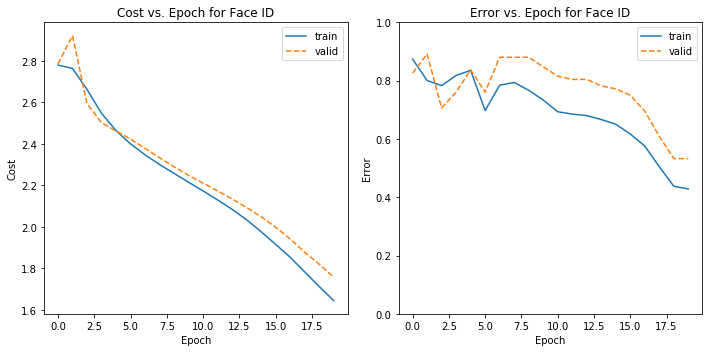

In [16]:
# training op
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# initialize variables and session
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()

    # initialize cost and error variables
    train_costs = []
    train_errors = []
    valid_costs = []
    valid_errors = []
    test_costs = []
    test_errors = []

    for epoch in range(n_epochs):
        if (epoch % 10) == 0:
            print("> epoch: {}".format(epoch))

        # train epoch cost and error
        train_costs = np.append(train_costs, cost.eval(feed_dict={X: trainData, y: trainTarget, keep_prob: 1.0}))
        train_errors = np.append(train_errors, error.eval(feed_dict={X: trainData, y: trainTarget, keep_prob: 1.0}))

        # valid epoch cost and error
        valid_costs = np.append(valid_costs, cost.eval(feed_dict={X: validData, y: validTarget, keep_prob: 1.0}))
        valid_errors = np.append(valid_errors, error.eval(feed_dict={X: validData, y: validTarget, keep_prob: 1.0}))

        # test epoch cost and error
        test_costs = np.append(test_costs, cost.eval(feed_dict={X: testData, y: testTarget, keep_prob: 1.0}))
        test_errors = np.append(test_errors, error.eval(feed_dict={X: testData, y: testTarget, keep_prob: 1.0}))

        # training step
        sess.run(optimizer, feed_dict={X: trainData, y: trainTarget, keep_prob: keep_probability})

    # print losses and errors
    lowest_valid_error_epoch = np.argmin(valid_errors)
    print("lowest validation error epoch: {}".format(lowest_valid_error_epoch))
    print("train_error: {0:0.3f}".format(train_errors[lowest_valid_error_epoch]))
    print("valid_error: {0:0.3f}".format(valid_errors[lowest_valid_error_epoch]))
    print("test_error: {0:0.3f}".format(test_errors[lowest_valid_error_epoch]))

    # plot loss and error vs. epoch
    plot_figures(train_costs, train_errors, valid_costs, valid_errors, task)